# Figure 4

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm

from zebrafish_rtrbm.models.RBM import RBM
from zebrafish_rtrbm.models.RTRBM import RTRBM
from zebrafish_rtrbm.utils.poisson_surrogate_data import PoissonTimeShiftedData
from zebrafish_rtrbm.utils.data_methods import create_U_hat
from zebrafish_rtrbm.utils.data_methods import reshape
from zebrafish_rtrbm.utils.data_methods import resample

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

from scipy.stats import pearsonr
from scipy.signal import correlate2d
from matplotlib.ticker import LogFormatterExponent

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In this notebook we inspect the ability of the RTRBM to extract temporal dynamics of neural assemblies as a function of the interaction time. We hypothesise it is crucial to sample the data at the right frequency, such that most interactions happen at the same delay as the sampling. We test this by creating surrogate data that has temporal interactions with a delay of 4 time-steps. By down-sampling this data, training RTRBMs and quantifying their reconstruction performance we test this hypothesis.

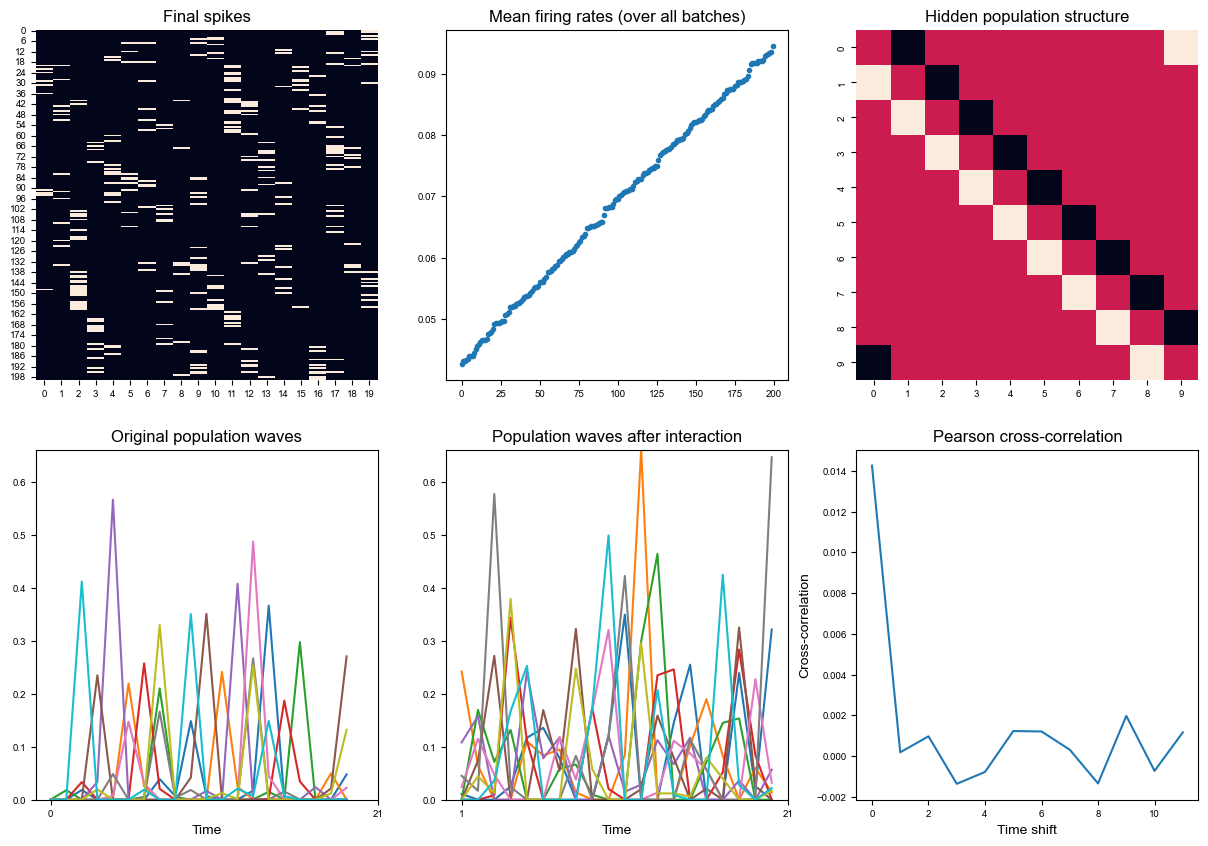

In [2]:
n_h = 10 # number of populations and hidden units
neurons_per_population = 20 # number of neurons per population
delay = 1 # population interaction delay

U_original = 0.7 * create_U_hat(n_h) # noticable but decaying connection. *1 = sustained feedback, >1 = positive feedback loop

int_range = [5, 10]  # interval range external input
max_fr = 0.6 # max firing rate of external input
std_range = [0.1, 0.5] # width of gaussian shaped peaks of external input

s = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=500,
    time_steps_per_batch=100, steps_to_settle=25,
    delay=delay, U=U_original,
    int_range=int_range, max_fr=max_fr, std_range=std_range,
    seed=1,
)

axes = s.plot_stats(T=20)
plt.show()

# Training

In [3]:
data_dir = '../data/figure4_downsampling'  # Directory path to save the model files to

In [4]:
n_runs = 10

n_h = 10 # number of populations and hidden units
neurons_per_population = 20 # number of neurons per population
delay = 4 # population interaction delay

U_original = 0.7 * create_U_hat(n_h) # noticable but decaying connection. *1 = sustained feedback, >1 = positive feedback loop

int_range = [5, 10]  # interval range external input
max_fr = 0.6 # max firing rate of external input
std_range = [0.1, 0.5] # width of gaussian shaped peaks of external input

In [5]:
rtrbm_list = []

for run in tqdm(range(1, n_runs+1)):

    run_dir = data_dir + '/run%s/'%(run)
    if not os.path.exists(run_dir):
        os.mkdir(run_dir)
    
    # create data
    s = PoissonTimeShiftedData(
        neurons_per_population=neurons_per_population,
        n_populations=n_h, n_batches=500,
        time_steps_per_batch=1000, steps_to_settle=25, # 1000 time steps, as max ds rate is 10
        delay=delay, U=U_original,
        int_range=int_range, max_fr=max_fr, std_range=std_range,
        seed=run)

    # down-sample data by 1, 2, ..., 10
    for d in range(1, 11):

        ds_dir = run_dir + '/downsampled%s/'%(d)
        if not os.path.exists(ds_dir):
            os.mkdir(ds_dir)

        if not os.path.exists(ds_dir + '/rtrbm'):
    
            # perform down sampling, only take 50000 time-steps
            data = resample(reshape(s.data.detach().clone()), sr=d, mode=2)[:, :50000]
    
            # reshape data to batches
            data = reshape(data, T=20, n_batches=2500)
    
            # take 2000 train batches and 500 test batches
            train, test = data[..., :2000], data[..., 2000:]
    
            # initialize and train RTRBM
            rtrbm = RTRBM(train, n_hidden=n_h, device='cuda')
            rtrbm.learn(batch_size=10, n_epochs=500, CDk=15, mom=0.9, wc=0.0002, disable_tqdm=True,
                        lr_schedule='geometric_decay', min_lr=5e-4, max_lr=1e-3)
    
            # save list
            torch.save(rtrbm, ds_dir + '/rtrbm')
            torch.save(train, ds_dir + '/train')
            torch.save(test, ds_dir + '/test')
    
            rtrbm_list += [rtrbm]
        
        else:
            device = torch.device('cpu')
            rtrbm_list += [torch.load(ds_dir + '/rtrbm', map_location=device)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


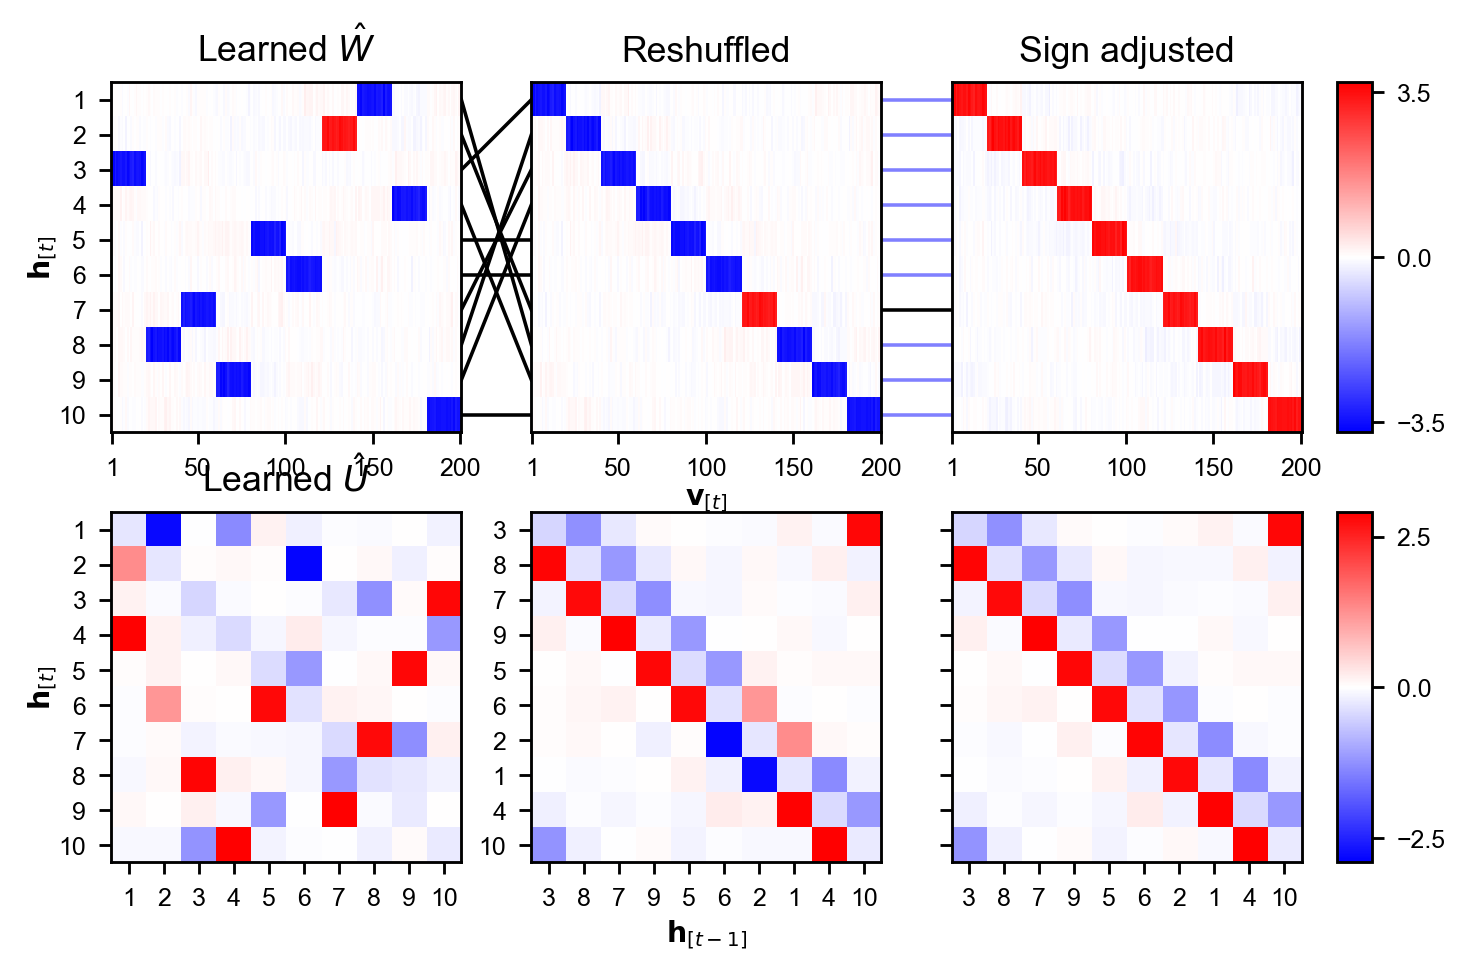

In [24]:
from zebrafish_rtrbm.utils.data_methods import shuffle_back

def U_to_W(x):
    # Coordinates in U plot to W plot
    return neurons_per_population*(x + 0.5) - 0.5

#rtrbm = rtrbm_list[94]
#rtrbm = rtrbm_list[0]
#rtrbm = rtrbm_list[83]
rtrbm = rtrbm_list[33]

W = rtrbm.W.cpu()
U = rtrbm.U.cpu()

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

W_trained, U_trained = shuffle_back(W, U, W_true=W_hat, allow_duplicates = False)

# find shuffle (used for further analysis)
shuffle = np.empty(n_h, dtype='int')
for i in range(n_h):
    shuffle[i] = np.where(W[:, 0] == W_trained[i, 0])[0][0]

# Check if reshuffle is correct
# reshuffled_W = np.copy(W)
# reshuffled_W = reshuffled_W[shuffle, :]
# print(np.allclose(W_trained, reshuffled_W))


# correct the U signs
unit_signs = np.empty(n_h, dtype='int')

for unit in range(n_h):
    # mean of associated visible units
    mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
    
    unit_signs[unit] = np.sign(mean_weight)

    
###############
# Plot result #
###############
    
fig, ax = plt.subplots(ncols=3, nrows=2, figsize = (6, 4), dpi=256)
W_lim = float(np.abs(W_trained).max())

# PLOT IMAGES
ax[0, 0].set_title(r"Learned $\hat{W}$", fontsize=10)
ax[0, 0].imshow(W, cmap='bwr', vmin=-W_lim, vmax=W_lim, aspect = neurons_per_population, interpolation = 'none')
 
ax[0, 1].set_title("Reshuffled", fontsize=10)
ax[0, 1].imshow(W_trained, cmap='bwr', vmin=-W_lim, vmax=W_lim, aspect = neurons_per_population, interpolation = 'none')
    
ax[0, 2].set_title("Sign adjusted", fontsize=10)
W_img = ax[0, 2].imshow(W_trained * unit_signs[:, np.newaxis], cmap='bwr', vmin=-W_lim, vmax=W_lim, aspect = neurons_per_population, interpolation = 'none')

U_lim = float(np.abs(U_trained).max())
ax[1, 0].set_title(r"Learned $\hat{U}$", fontsize=10)
ax[1, 0].imshow(U, cmap='bwr', vmin=-U_lim, vmax=U_lim)
ax[1, 1].imshow(U_trained, cmap='bwr', vmin=-U_lim, vmax=U_lim)
U_img = ax[1, 2].imshow(U_trained * np.outer(unit_signs, unit_signs), cmap='bwr', vmin=-U_lim, vmax=U_lim)

# SET TICKS
for i in range(3):
    ax[0, i].set_xticks([0, 50-1, 100-1, 150-1, 200-1], [1, 50, 100, 150, 200])

ax[0, 0].set_yticks(np.arange(10), np.arange(10)+1)
ax[0, 1].set_yticks([])
ax[0, 2].set_yticks([])

ax[1, 0].set_xticks(np.arange(10), np.arange(10)+1)
ax[1, 1].set_xticks(np.arange(10), shuffle+1)
ax[1, 2].set_xticks(np.arange(10), shuffle+1)

ax[1, 0].set_yticks(np.arange(10), np.arange(10)+1)
ax[1, 1].set_yticks(np.arange(10), shuffle+1)
ax[1, 2].set_yticks(np.arange(10), [])

# SHOW RESHUFFLING
for i in range(10):
    #ax[1, 0].plot([9.5, 11.5], [shuffle[i], i], c='k', clip_on=False, linewidth=1, zorder=-1)
    ax[0, 0].plot([U_to_W(9.5), U_to_W(11.5)], [shuffle[i], i], c='k', clip_on=False, linewidth=1, zorder=-1)
#ax[1, 0].set_xlim([-0.5, 9.5])
ax[0, 0].set_xlim([-0.5, U_to_W(9.5)])

# SHOW SIGN CORRECTION
for i in range(10):
    if unit_signs[shuffle[i]] == 1:
        c = 'k'
    else:
        c = (0.5, 0.5, 1.0)
    ax[0, 1].plot([U_to_W(9.5), U_to_W(11.5)], 2*[shuffle[i]], c=c, clip_on=False, linewidth=1, zorder=-1)
ax[0, 1].set_xlim([-0.5, U_to_W(9.5)])

# LABELS AND COLORBAR
ax[0, 1].set_xlabel('$\mathbf{v}_{[t]}$', fontsize=8, labelpad=2)
ax[0, 0].set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

ax[1, 1].set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8, labelpad=2)
ax[1, 0].set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

cax = ax[1, 2].inset_axes([10.5, -0.5, 1, 10], transform=ax[1, 2].transData)
cbar = fig.colorbar(U_img, cax=cax)
cbar.ax.set_yticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=7)

cax = ax[0, 2].inset_axes([U_to_W(10.5), -0.5, 1*neurons_per_population, 10], transform=ax[0, 2].transData)
cbar = fig.colorbar(W_img, cax=cax)
cbar.ax.set_yticks([-3.5, 0, 3.5])
cbar.ax.tick_params(labelsize=7)

plt.show()

**Sampling from trained model to (somewhat) validate sign correction**

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.35it/s]


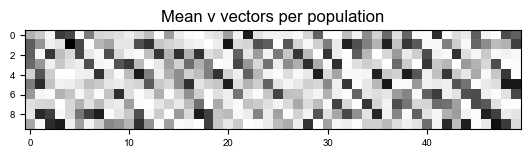

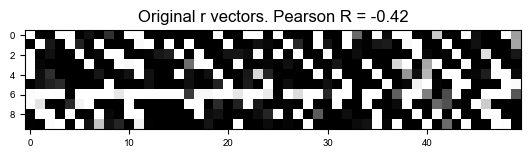

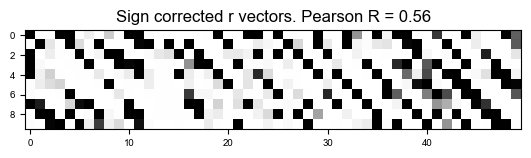

In [25]:
n_v = n_h*neurons_per_population

rtrbm = rtrbm_list[33]

rtrbm.device = 'cpu'

v_start = torch.zeros(n_v)
v_start[:] = 1
v_output, r_output = rtrbm.sample(v_start, chain=50, pre_gibbs_k=400, gibbs_k=100, mode=2)

T = v_output.shape[1]
meaned_output = np.empty([n_h, T])

for i in range(n_h):
    meaned_output[i] = v_output[(i*neurons_per_population):((i+1)*neurons_per_population), :, 0].mean(axis=0)

#plt.imshow(v_output[:, :, 0], cmap='binary')
plt.imshow(meaned_output, cmap='binary')
plt.title('Mean v vectors per population')
plt.show()

# Find aligned ordering of populations
W = rtrbm.W.cpu()
U = rtrbm.U.cpu()
W_trained, U_trained = shuffle_back(W, U, W_true=W_hat, allow_duplicates = False)

shuffle = np.empty(n_h, dtype='int')
for i in range(n_h):
    shuffle[i] = np.where(W[:, 0] == W_trained[i, 0])[0][0]

# correct the U signs
unit_signs = np.empty(n_h, dtype='int')

for unit in range(n_h):
    # mean of associated visible units
    mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
    
    unit_signs[unit] = np.sign(mean_weight)
    
# Reorder r accordingly
r = np.array(r_output[shuffle, :, 0])
flip = np.where(unit_signs == -1)[0]

r_flipped = r.copy()
r_flipped[flip] = 1 - r_flipped[flip]


plt.imshow(r, cmap='binary')
corr = np.corrcoef(r.ravel(), meaned_output.ravel())[0, 1]
plt.title("Original r vectors. Pearson R = {:.2f}".format(corr))
plt.show()

plt.imshow(r_flipped, cmap='binary')
corr = np.corrcoef(r_flipped.ravel(), meaned_output.ravel())[0, 1]
plt.title("Sign corrected r vectors. Pearson R = {:.2f}".format(corr))
plt.show()

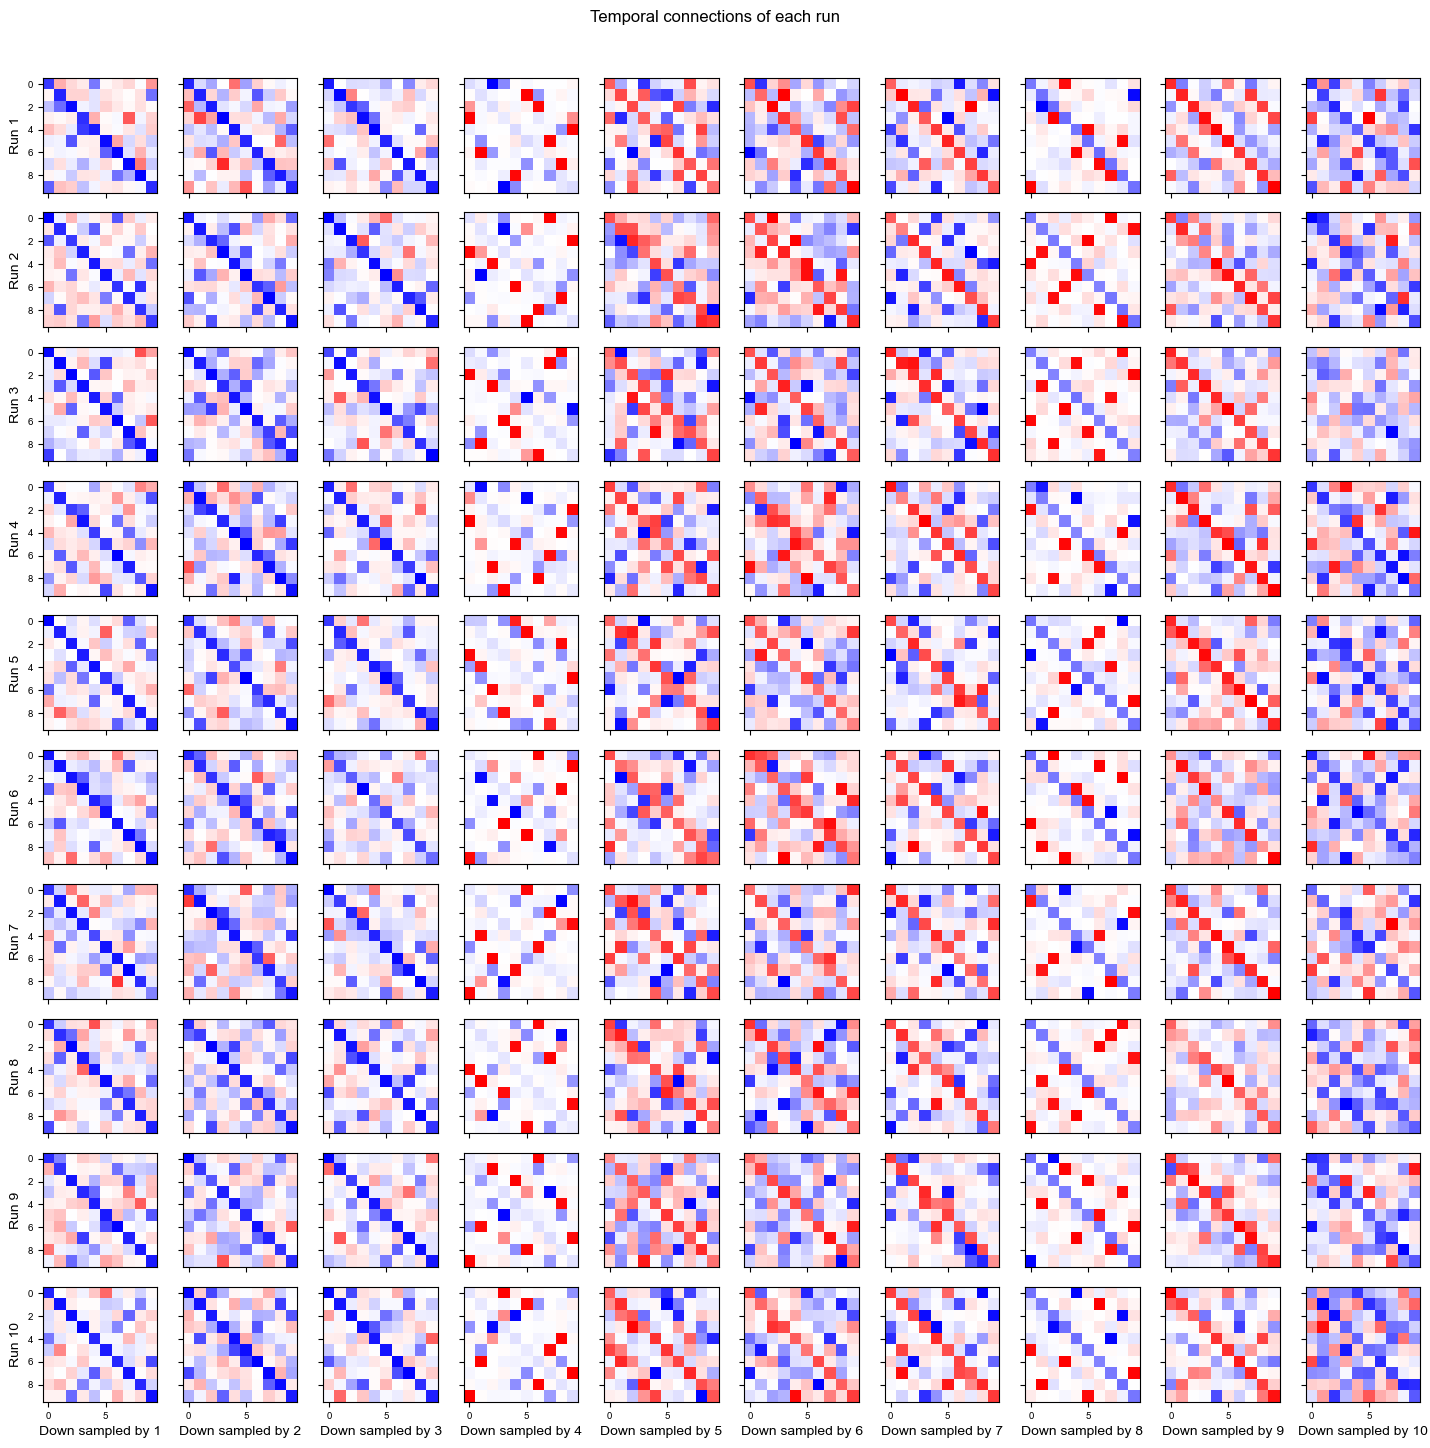

In [26]:
# Original U matrices
fig, axs = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):

    W_trained, U_trained = rtrbm.W.cpu(), rtrbm.U.cpu()
    lim = float(np.abs(U_trained).max())
    ax.imshow(U_trained, cmap=plt.get_cmap('bwr'), vmin=-lim, vmax=lim)

    row = i // 10
    col = i % 10
    if col == 0:
        ax.set_ylabel('Run %d' % (row + 1))
    if row == 9:
        ax.set_xlabel('Down sampled by %d' % (col + 1))

fig.suptitle('Temporal connections of each run')
plt.tight_layout(pad=3, h_pad=1.08, w_pad=1.08)

plt.show()

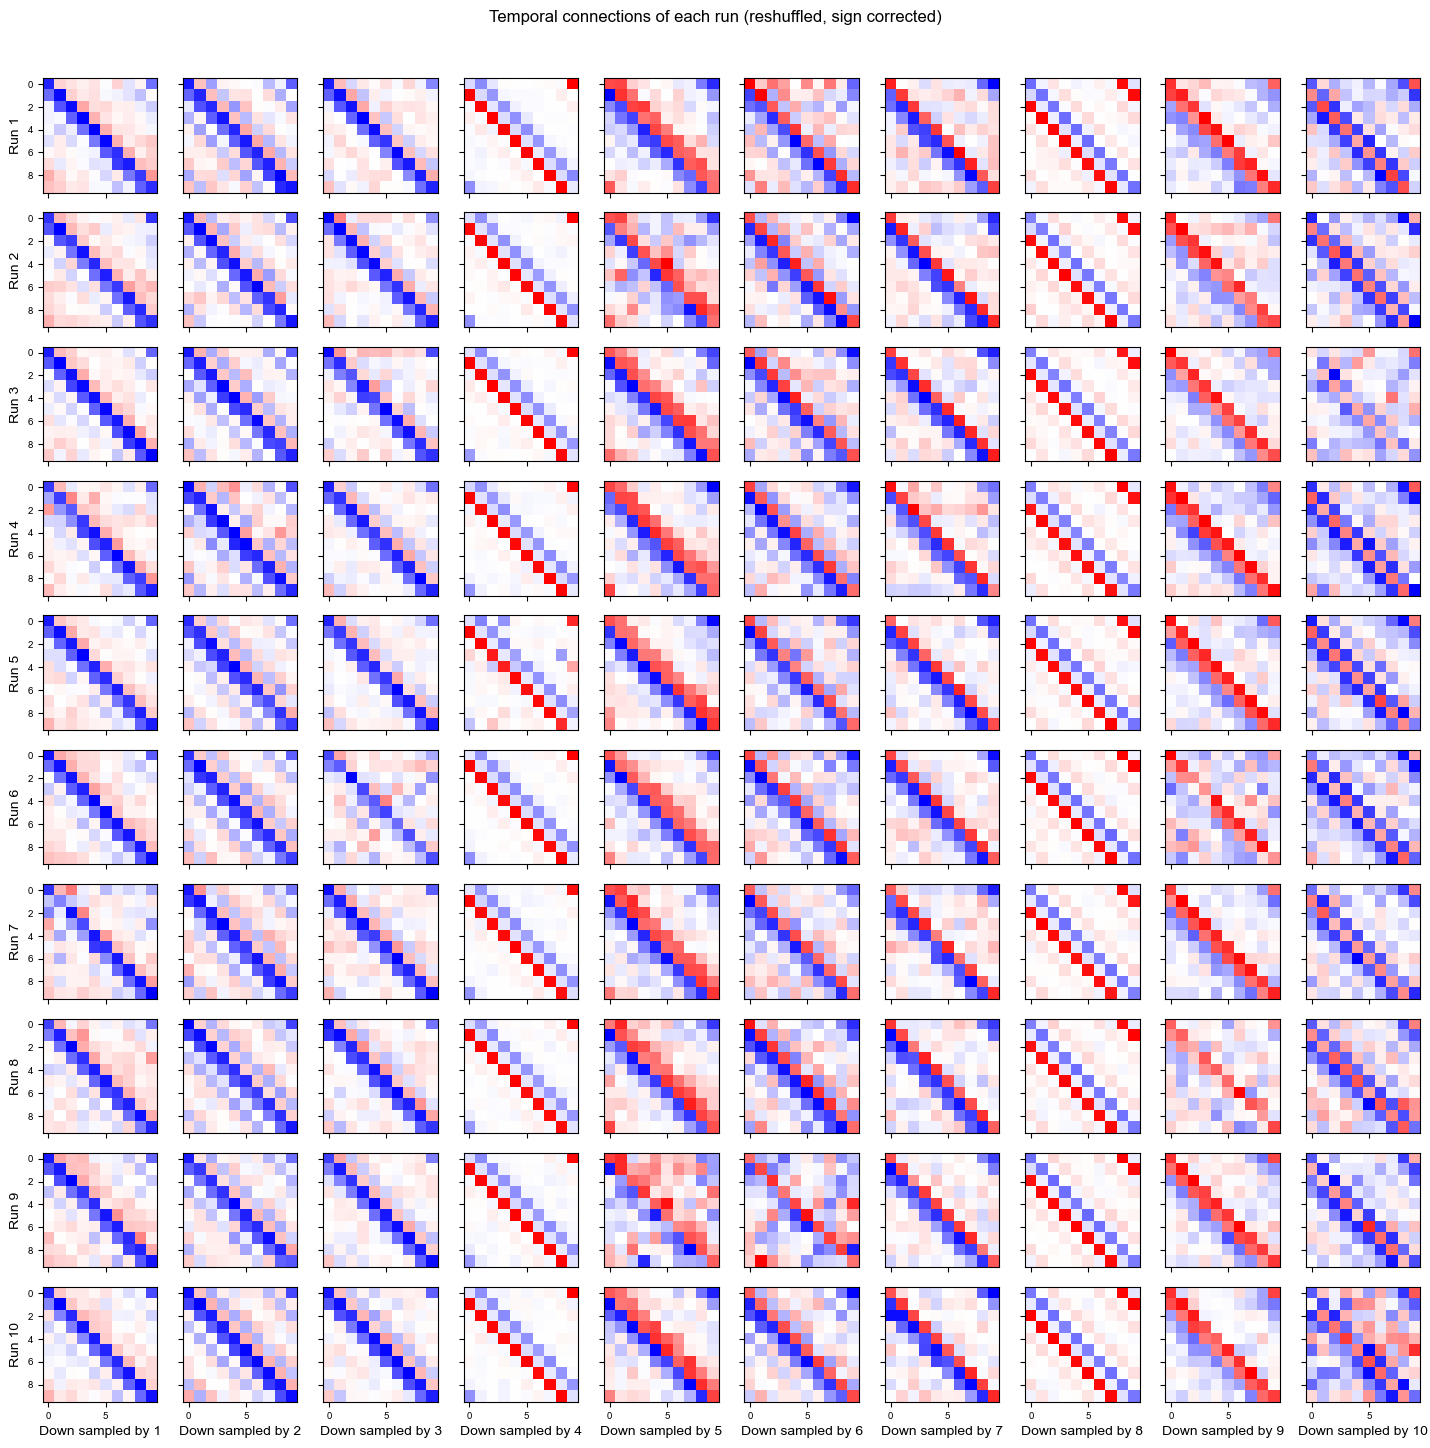

In [27]:
# Reshuffle (without duplicates), with sign correction
fig, axs = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
n_h, n_v = W_hat.shape
neurons_per_population = n_v // n_h 

for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):
    try:
        W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    except:
        continue
    # correct the U signs
    unit_signs = np.empty(n_h, dtype='int')
    
    for unit in range(n_h):
        # mean of population
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
        
#         # mean of all weights
#         mean_weight = W_trained[unit].mean()
        
        unit_signs[unit] = np.sign(mean_weight)
    
    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    
    # plot the result
    lim = float(np.abs(U_trained).max())
    
    ax.imshow(U_trained, cmap=plt.get_cmap('bwr'), vmin=-lim, vmax=lim)

    row = i // 10
    col = i % 10
    if col == 0:
        ax.set_ylabel('Run %d' % (row + 1))
    if row == 9:
        ax.set_xlabel('Down sampled by %d' % (col + 1))

fig.suptitle('Temporal connections of each run (reshuffled, sign corrected)')
plt.tight_layout(pad=3, h_pad=1.08, w_pad=1.08)

plt.show()

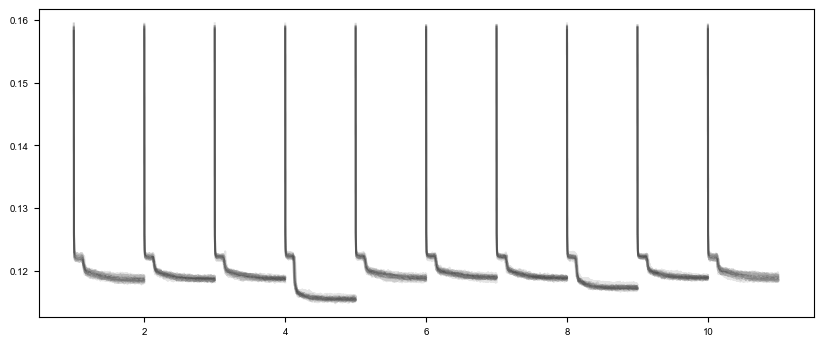

[10 10 10 10 10 10 10 10 10 10]


In [28]:
plt.figure(figsize = (10, 4))

n_converged = np.zeros(10, dtype='int')

for i in range(100):
    d = (i % 10) + 1
    n = i // 10
    x = np.linspace(0, 1, len(rtrbm_list[i].errors))
    plt.plot(x + d, rtrbm_list[i].errors, c='k', alpha=0.1)
    
    n_converged[d-1] += int(rtrbm_list[i].errors[-1] < 0.18)
plt.show()

print(n_converged)

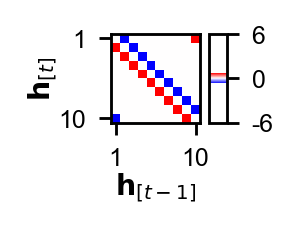

In [30]:
U_hat = 0.7 * create_U_hat(n_h)

plt.figure(figsize = (1, 1), dpi=256, layout='constrained')
extent = [0.5, 10.5, 10.5, 0.5]
img = plt.imshow(U_hat, cmap='bwr', extent=extent)
plt.gca().set_xticks([1, 10], [1, 10], fontsize=7)
plt.gca().set_yticks([1, 10], [1, 10], fontsize=7)

plt.gca().set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8, labelpad=0)
plt.gca().set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

cax = plt.gca().inset_axes([10.5 + 1, 0.5, 2, 10], transform=plt.gca().transData)
cbar = fig.colorbar(img, cax=cax)
cbar.ax.set_yticks([-6, 0, 6], [-6, 0, 6], fontsize=7)

#plt.savefig('images/U_original.svg')
plt.show()

# Similarity between $U$ and $\hat{U}$

In [31]:
# Calculate cosine similarity
from scipy.stats import zscore
    
def cosine_similarity(A, B):
    return np.trace(np.matmul(A.T, B)) / (np.linalg.norm(A) * np.linalg.norm(B))

C = np.empty(len(rtrbm_list))

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, rtrbm in enumerate(rtrbm_list):
    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    
    
    # Correct the U signs
    unit_signs = np.empty(n_h, dtype='int')
    for unit in range(n_h):
        # Population sign is taken as the sign of the mean weight
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
        unit_signs[unit] = np.sign(mean_weight)

    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    
    # Take z-score
    #zscored_U_hat = zscore(U_hat.ravel()).reshape(U_hat.shape)
    #zscored_U_trained = zscore(U_trained.ravel()).reshape(U_trained.shape)
    
    C[i] = cosine_similarity(U_trained, U_hat)
    
C = C.reshape((n_h, n_h))

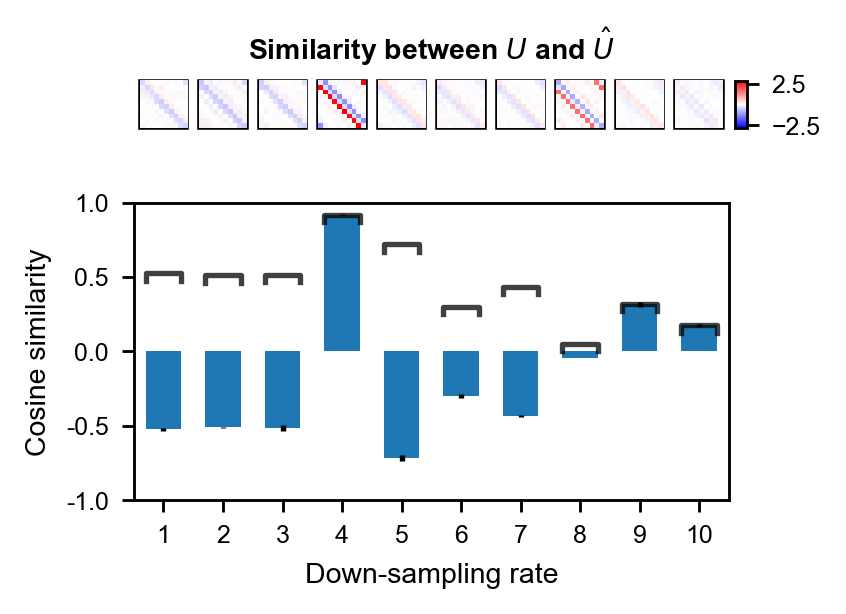

In [32]:
# Show cosine similarity and best matches
from matplotlib.patches import Rectangle

barwidth = 0.6
Uwidth = 0.8

# Plot result
fig, ax = plt.subplots(figsize = (3, 2), dpi=256)
ax.bar(np.arange(10) + 1, np.mean(C, axis=0), zorder=0, width=barwidth)
ax.errorbar(np.arange(10) + 1, np.mean(C, axis=0), np.std(C, axis=0) / np.sqrt(10), c='k', fmt=' ', zorder=2)

# Add markers indicating absolute score
for i in range(10):
    height = np.abs(np.mean(C[:, i]))
    
    x_start = i + 1 - barwidth/2
    x_end = i + 1 + barwidth/2
    
    y_start = max(0, height-0.05)
    ax.plot([x_start, x_start, x_end, x_end], [y_start, height, height, y_start], c='k', alpha=0.75, zorder=1)#, linestyle='--')

ax.set_title('Similarity between $U$ and $\hat{U}$', fontsize=8, fontweight='bold')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_ylabel('Cosine similarity', fontsize=8)
ax.set_yticks(np.arange(-1, 1.1, 0.5))
ax.set_yticklabels(np.arange(-1, 1.1, 0.5), fontsize=7)
ax.set_ylim([-1, 1])

ax.set_xlabel('Down-sampling rate', fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=7)
ax.set_xlim([0.5, 10.5])

lim = 0
for i in range(10):
    U = rtrbm_list[i + 10*np.argmax(np.abs(C[:, i]))].U.cpu()
    highest = torch.max(torch.abs(U))
    if highest > lim:
        lim = highest
    
# Add trained U matrices
for i in range(10):
    
    # NOTE: For some where ds != 4, the best performing model has a non-nice structure, whereas the
    # worst performing ones do have a nice structure. This is thus not a fair visual comparison,
    # as this way it looks like the other ds rates are not able to find any structure.
    
    # Because of this, the U matrices with the largest correlation are shown instead,
    # which are more representative of the learned matrices
    
    #rtrbm = rtrbm_list[i + 10*np.argmin(test_errors[i])] # best performance comparison
    rtrbm = rtrbm_list[i + 10*np.argmax(np.abs(C[:, i]))] # best visual comparison
    U = rtrbm.U.cpu()

    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    #lim = torch.max(torch.abs(U_trained))
    
    # correct the U signs
    unit_signs = np.empty(n_h, dtype='int')

    for unit in range(n_h):
        # mean of population
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()

        unit_signs[unit] = np.sign(mean_weight)

    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    
    offset = 0.5 #(1 - Uwidth)/aspect # offset above figure

    aspect = 10 / 4
    
    extent = [i+1 - (Uwidth/2), i+1 + (Uwidth/2), 1 + offset, 1 + offset + Uwidth/aspect]
    img = ax.imshow(U_trained, vmin=-lim, vmax=lim, cmap='bwr', interpolation='none', extent=extent, clip_on=False, zorder=1)
    ax.add_patch(Rectangle([extent[0], extent[2]], width=Uwidth, height=Uwidth/aspect, edgecolor='k', facecolor='none', clip_on=False, zorder=0))

cax = ax.inset_axes([extent[0] + 1, extent[2], 0.2, Uwidth/aspect], transform=ax.transData)
cbar = fig.colorbar(img, cax=cax, ticks=[-2.5, 2.5])
    
ax.set_aspect(aspect)
#plt.savefig('images/cosine_similarity.svg')#, dpi=256)
plt.show()

# Test error

In [34]:
# Generate own test data, for consistency

# create data
s = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=500,
    time_steps_per_batch=1000, steps_to_settle=25, # 1000 time steps, as max ds rate is 10
    delay=delay, U=U_original,
    int_range=int_range, max_fr=max_fr, std_range=std_range,
    seed=1)

# discard first 25 timesteps, as initial activity is different from long time activity
test_data = s.data[:, 25:].detach().clone()

In [35]:
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [37]:
#####################################################################
# THIS CODE CALCULATES ALL TEST ERRORS AND TAKES QUITE LONG TO RUN. #
# SEE BELOW TO IMPORT PRE-CALCULATED TEST ERRORS                    #
#####################################################################

test_errors = np.empty([10, 10]) # shape (ds rates, models)
theoretical_errors = np.empty([10]) # error depends on the distribution of test data, so is different for each ds rate

device = torch.device('cpu')
CDk = 40 # seems to be a more stable number of iterations. At 20 the error is still increasing for most models

# While it is possible to run this on the gpu instead of the cpu, it requires a lot of memory

torch.manual_seed(0)

for i, rtrbm in tqdm(enumerate(rtrbm_list), total=len(rtrbm_list)):
    d = (i % 10) + 1
    n = i // 10
    
    n_batches_to_use = test_data.shape[2]
    
    # Reshape such that every single time point is sampled as if it was a batch
    v_data = reshape_fortran(test_data[:, ::d, :n_batches_to_use][:, :100], shape=[test_data.shape[0], 100*n_batches_to_use])
    
    if i < 10:
        p_positive = torch.mean(v_data, axis=1) # mean firing rate per neuron
        theoretical_errors[i] = torch.mean(2*p_positive*(1 - p_positive)) # MSE of mismatch for binary signal
        # (theoretical error is confirmed through simulation)
        
        # Lower bound equivalent to double sampling from underlying population/neuron distributions
#         waves = s.neuron_waves_interact.detach().clone()[:, 113::d][:, :100]
#         e = torch.exp(-waves)
#         mean_variance = torch.mean(e * (1 - e))
#         lower_bounds[i] = 2*mean_variance
    
    rtrbm.device = torch.device('cpu')
    vt, rt = rtrbm.sample(v_data, chain=1, pre_gibbs_k=CDk, gibbs_k=1, disable_tqdm=True) # sample one time step ahead
    vt = vt[:, 0] # only one time step is estimated
    
    time_steps_per_batch = 100

    # Align test data with sampled data
    first_of_batch = np.arange(n_batches_to_use, dtype='int')*time_steps_per_batch
    last_of_batch = np.arange(1, n_batches_to_use + 1, dtype='int')*time_steps_per_batch - 1

    v_data_subset = np.delete(v_data, first_of_batch, axis=1)
    vt_subset = np.delete(vt, last_of_batch, axis=1)
    
    # MSE (this formulation only holds if both variables are binary)
    test_errors[d-1, n] = torch.mean(torch.abs(v_data_subset - vt_subset))

  9%|███████▍                                                                          | 9/100 [00:38<06:31,  4.30s/it]


RuntimeError: shape '[50000, 200]' is invalid for input of size 9800000

In [61]:
# save results
# np.save('NEW_one_step_ahead_errors.npy', test_errors)
# np.save('NEW_theoretical_errors.npy', theoretical_errors)

# load results
test_errors = np.load('NEW_one_step_ahead_errors.npy') # shape (n_ds, n_model)
theoretical_errors = np.load('NEW_theoretical_errors.npy') # shape (n_ds) # Mean firing rate per neuron
#theoretical_errors = np.load('theoretical_errors_meanFR.npy') # shape (n_ds) # Single mean firing rate for all neurons


# SEE BOTTOM OF NOTEBOOK FOR SIMULATION TO ACHIEVE THESE VALUES
acc_upper_bound = 1 - np.load('MSE_lower_bound_mean.npy')
acc_upper_err = np.load('MSE_lower_bound_sem.npy')

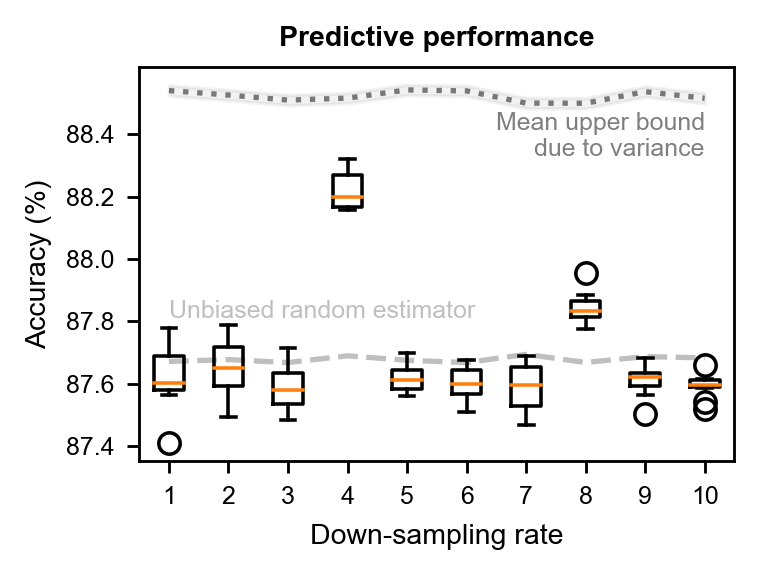

In [78]:
fig, ax = plt.subplots(figsize = (3, 2), dpi=256)
ax.ticklabel_format(style='sci', axis='y')

ax.boxplot(1 - test_errors.T, positions = np.arange(10) + 1, zorder=1)

# Random process MSE (with same <v>)
ax.plot(np.arange(10) + 1, 1 - theoretical_errors, c='k', alpha=0.25, linestyle='--', zorder=-1)

# MSE due to variance in sampling when generating data
ax.plot(np.arange(10) + 1, acc_upper_bound, c='k', alpha=0.5, linestyle='dotted', zorder=-1)
ax.fill_between(np.arange(10) + 1, acc_upper_bound - acc_upper_err, acc_upper_bound + acc_upper_err,
               color = 'k', alpha=0.05, zorder=-2)

ax.set_yticks(np.arange(0.874, 0.885, 0.002), 100*np.arange(0.874, 0.885, 0.002))
ax.text(1, np.max(1 - theoretical_errors) + 0.001, "Unbiased random estimator", fontsize=7, ha='left', va='bottom', alpha=0.25)
ax.text(10, np.min(acc_upper_bound - acc_upper_err) - 0.0001, "Mean upper bound\ndue to variance", fontsize=7, ha='right', va='top', alpha=0.5)

ax.set_ylabel('Accuracy (%)', fontsize=8)
    
    
# Add significance stars
# for i in range(10):
#     if n_stars[i] > 0:

#         if n_stars[i] <= 3:
#             text = '*'*n_stars[i]
#         else:
#             text = str(n_stars[i]) + '*'

#         if i in [3, 7]: # show below
#             ax.text(i + 1, np.min(1 - test_errors[i]) - 0.0005, text, ha='center', va='top')
#         else: # show above
#             ax.text(i + 1, np.max(1 - test_errors[i]) + 0.000, text, ha='center', va='bottom')


ax.set_title('Predictive performance', fontsize=8, fontweight='bold')

ax.set_xlabel('Down-sampling rate', fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=7)
ax.set_xlim([0.5, 10.5])

plt.show()

In [74]:
from scipy.stats import mannwhitneyu as MWU
from scipy.stats import wilcoxon
# from scipy.stats import ttest_1samp
# from scipy.stats import ttest_ind

n_stars = np.empty([10], dtype='int')

# Test if better than random (wilcoxon)
print("Better than random?")
for ds in range(1, 11):
    p_value = wilcoxon([theoretical_errors[ds-1]]*10, test_errors[ds-1], alternative='greater')[1]
    #p_value = ttest_1samp(test_errors[ds-1], popmean=theoretical_errors[ds-1], alternative='less')[1]
    p_value *= 10 # bonferroni correction
    effect_size = (theoretical_errors[ds-1] - np.mean(test_errors[ds-1])) / np.std(test_errors[ds-1], ddof=1)
    
    
    if p_value >= 0.05:
        n_stars[ds-1] = 0
    else:
        n_stars[ds-1] = int(np.floor(-np.log10(p_value)))
    
    
    if n_stars[ds-1] == 0:
        print("{}x NOT significant\tp = {:.5f}\td = {:.2f}".format(ds, p_value, effect_size))
    else:
        print("{}x  is significant{}\tp = {:.5f}\td = {:.2f}".format(ds, n_stars[ds-1]*'*', p_value, effect_size))

# Test if better than other (MWU)
compare = 4

print("\nIs {}x downsampling better?".format(compare))
for ds in range(1, 11):
    if ds == compare:
        print('--')
        continue
    
    p_value = MWU(test_errors[ds-1], test_errors[compare-1], alternative='greater')[1]
    #p_value = ttest_ind(test_errors[ds-1], test_errors[compare-1], equal_var=False, alternative='greater')[1]
    p_value *= 9 # bonferroni correction
    
    pooled_s = np.sqrt((np.var(test_errors[ds - 1]) + np.var(test_errors[compare - 1]) )/2 )
    effect_size = (np.mean(test_errors[ds-1]) - np.mean(test_errors[compare-1])) / pooled_s
    
    if p_value >= 0.05:
        n_stars_ds = 0
    else:
        n_stars_ds = int(np.floor(-np.log10(p_value)))
    
#     if p_value < 0.001:
#         n_stars_ds = 3
#     elif p_value < 0.01:
#         n_stars_ds = 2
#     elif p_value < 0.05:
#         n_stars_ds = 1
#     else:
#         n_stars_ds = 0
    
    
    if n_stars_ds == 0:
        print("{}x NOT significant\tp = {:.5f}\td = {:.2f}".format(ds, p_value, effect_size))
    else:
        print("{}x  is significant{}\tp = {:.5f}\td = {:.2f}".format(ds, n_stars_ds*'*', p_value, effect_size))

Better than random?
1x NOT significant	p = 8.62305	d = -0.45
2x NOT significant	p = 7.21680	d = -0.26
3x NOT significant	p = 9.95117	d = -1.13
4x  is significant**	p = 0.00977	d = 8.60
5x NOT significant	p = 9.99023	d = -1.42
6x NOT significant	p = 9.99023	d = -1.28
7x NOT significant	p = 10.00000	d = -1.35
8x  is significant**	p = 0.00977	d = 3.55
9x NOT significant	p = 10.00000	d = -1.56
10x NOT significant	p = 10.00000	d = -2.33

Is 4x downsampling better?
1x  is significant***	p = 0.00082	d = 7.18
2x  is significant***	p = 0.00082	d = 7.12
3x  is significant***	p = 0.00082	d = 9.96
--
5x  is significant***	p = 0.00082	d = 12.07
6x  is significant***	p = 0.00082	d = 11.42
7x  is significant***	p = 0.00082	d = 9.52
8x  is significant***	p = 0.00082	d = 7.05
9x  is significant***	p = 0.00082	d = 11.50
10x  is significant***	p = 0.00082	d = 12.84


4x downsampling is better than all (p = 0.00082, effect size >= 7.05)
8x downsampling is better than all except 4 (p <= 0.00098, effect size >= 2.55)

In [60]:
#####################################################################
# THIS CODE CALCULATES ALL TEST ERRORS AND TAKES QUITE LONG TO RUN. #
# SEE BELOW TO IMPORT PRE-CALCULATED TEST ERRORS                    #
#####################################################################

test_errors = np.empty([10, 10]) # shape (ds rates, models)
theoretical_errors = np.empty([10]) # error depends on the distribution of test data, so is different for each ds rate

device = torch.device('cpu')
CDk = 40 # seems to be a more stable number of iterations. At 20 the error is still increasing for most models

# While it is possible to run this on the gpu instead of the cpu, it requires a lot of memory

torch.manual_seed(0)

for i, rtrbm in tqdm(enumerate(rtrbm_list), total=len(rtrbm_list)):
    d = (i % 10) + 1
    n = i // 10
    
    n_batches_to_use = test_data.shape[2]
    
    # Reshape such that every single time point is sampled as if it was a batch
    v_data = reshape_fortran(test_data[:, ::d, :n_batches_to_use][:, :100], shape=[test_data.shape[0], 100*n_batches_to_use])
    
    if i < 10:
        p_positive = torch.mean(v_data, axis=1) # mean firing rate per neuron
        theoretical_errors[i] = torch.mean(2*p_positive*(1 - p_positive)) # MSE of mismatch for binary signal
        # (theoretical error is confirmed through simulation)
        
        # Lower bound equivalent to double sampling from underlying population/neuron distributions
#         waves = s.neuron_waves_interact.detach().clone()[:, 113::d][:, :100]
#         e = torch.exp(-waves)
#         mean_variance = torch.mean(e * (1 - e))
#         lower_bounds[i] = 2*mean_variance
    
    rtrbm.device = torch.device('cpu')
    vt, rt = rtrbm.sample(v_data, chain=1, pre_gibbs_k=CDk, gibbs_k=1, disable_tqdm=True) # sample one time step ahead
    vt = vt[:, 0] # only one time step is estimated
    
    time_steps_per_batch = 100

    # Align test data with sampled data
    first_of_batch = np.arange(n_batches_to_use, dtype='int')*time_steps_per_batch
    last_of_batch = np.arange(1, n_batches_to_use + 1, dtype='int')*time_steps_per_batch - 1

    v_data_subset = np.delete(v_data, first_of_batch, axis=1)
    vt_subset = np.delete(vt, last_of_batch, axis=1)
    
    # MSE (this formulation only holds if both variables are binary)
    test_errors[d-1, n] = torch.mean(torch.abs(v_data_subset - vt_subset))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


In [61]:
# save results
# np.save('NEW_one_step_ahead_errors.npy', test_errors)
# np.save('NEW_theoretical_errors.npy', theoretical_errors)

# load results
test_errors = np.load('NEW_one_step_ahead_errors.npy') # shape (n_ds, n_model)
theoretical_errors = np.load('NEW_theoretical_errors.npy') # shape (n_ds) # Mean firing rate per neuron
#theoretical_errors = np.load('theoretical_errors_meanFR.npy') # shape (n_ds) # Single mean firing rate for all neurons


# SEE BOTTOM OF NOTEBOOK FOR SIMULATION TO ACHIEVE THESE VALUES
acc_upper_bound = 1 - np.load('MSE_lower_bound_mean.npy')
acc_upper_err = np.load('MSE_lower_bound_sem.npy')

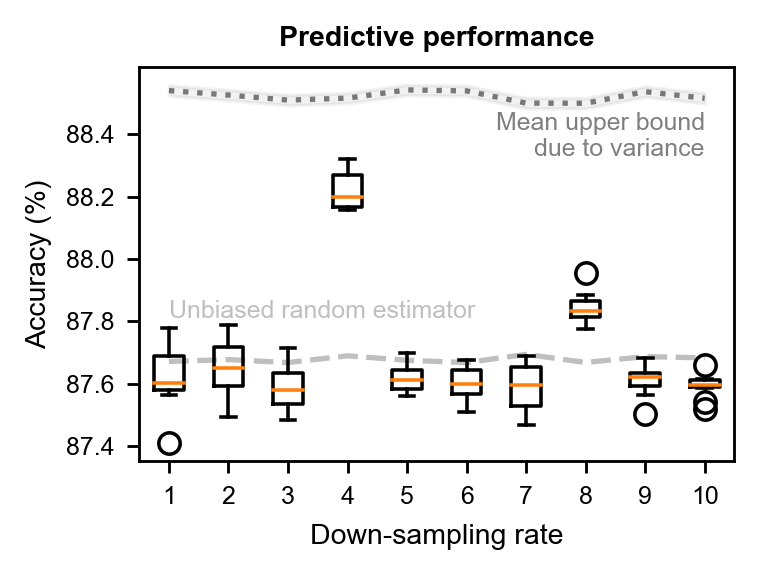

In [78]:
fig, ax = plt.subplots(figsize = (3, 2), dpi=256)
ax.ticklabel_format(style='sci', axis='y')

ax.boxplot(1 - test_errors.T, positions = np.arange(10) + 1, zorder=1)

# Random process MSE (with same <v>)
ax.plot(np.arange(10) + 1, 1 - theoretical_errors, c='k', alpha=0.25, linestyle='--', zorder=-1)

# MSE due to variance in sampling when generating data
ax.plot(np.arange(10) + 1, acc_upper_bound, c='k', alpha=0.5, linestyle='dotted', zorder=-1)
ax.fill_between(np.arange(10) + 1, acc_upper_bound - acc_upper_err, acc_upper_bound + acc_upper_err,
               color = 'k', alpha=0.05, zorder=-2)

ax.set_yticks(np.arange(0.874, 0.885, 0.002), 100*np.arange(0.874, 0.885, 0.002))
ax.text(1, np.max(1 - theoretical_errors) + 0.001, "Unbiased random estimator", fontsize=7, ha='left', va='bottom', alpha=0.25)
ax.text(10, np.min(acc_upper_bound - acc_upper_err) - 0.0001, "Mean upper bound\ndue to variance", fontsize=7, ha='right', va='top', alpha=0.5)

ax.set_ylabel('Accuracy (%)', fontsize=8)
    
    
# Add significance stars
# for i in range(10):
#     if n_stars[i] > 0:

#         if n_stars[i] <= 3:
#             text = '*'*n_stars[i]
#         else:
#             text = str(n_stars[i]) + '*'

#         if i in [3, 7]: # show below
#             ax.text(i + 1, np.min(1 - test_errors[i]) - 0.0005, text, ha='center', va='top')
#         else: # show above
#             ax.text(i + 1, np.max(1 - test_errors[i]) + 0.000, text, ha='center', va='bottom')


ax.set_title('Predictive performance', fontsize=8, fontweight='bold')

ax.set_xlabel('Down-sampling rate', fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=7)
ax.set_xlim([0.5, 10.5])

plt.show()

In [74]:
from scipy.stats import mannwhitneyu as MWU
from scipy.stats import wilcoxon
# from scipy.stats import ttest_1samp
# from scipy.stats import ttest_ind

n_stars = np.empty([10], dtype='int')

# Test if better than random (wilcoxon)
print("Better than random?")
for ds in range(1, 11):
    p_value = wilcoxon([theoretical_errors[ds-1]]*10, test_errors[ds-1], alternative='greater')[1]
    #p_value = ttest_1samp(test_errors[ds-1], popmean=theoretical_errors[ds-1], alternative='less')[1]
    p_value *= 10 # bonferroni correction
    effect_size = (theoretical_errors[ds-1] - np.mean(test_errors[ds-1])) / np.std(test_errors[ds-1], ddof=1)
    
    
    if p_value >= 0.05:
        n_stars[ds-1] = 0
    else:
        n_stars[ds-1] = int(np.floor(-np.log10(p_value)))
    
    
    if n_stars[ds-1] == 0:
        print("{}x NOT significant\tp = {:.5f}\td = {:.2f}".format(ds, p_value, effect_size))
    else:
        print("{}x  is significant{}\tp = {:.5f}\td = {:.2f}".format(ds, n_stars[ds-1]*'*', p_value, effect_size))

# Test if better than other (MWU)
compare = 4

print("\nIs {}x downsampling better?".format(compare))
for ds in range(1, 11):
    if ds == compare:
        print('--')
        continue
    
    p_value = MWU(test_errors[ds-1], test_errors[compare-1], alternative='greater')[1]
    #p_value = ttest_ind(test_errors[ds-1], test_errors[compare-1], equal_var=False, alternative='greater')[1]
    p_value *= 9 # bonferroni correction
    
    pooled_s = np.sqrt((np.var(test_errors[ds - 1]) + np.var(test_errors[compare - 1]) )/2 )
    effect_size = (np.mean(test_errors[ds-1]) - np.mean(test_errors[compare-1])) / pooled_s
    
    if p_value >= 0.05:
        n_stars_ds = 0
    else:
        n_stars_ds = int(np.floor(-np.log10(p_value)))
    
#     if p_value < 0.001:
#         n_stars_ds = 3
#     elif p_value < 0.01:
#         n_stars_ds = 2
#     elif p_value < 0.05:
#         n_stars_ds = 1
#     else:
#         n_stars_ds = 0
    
    
    if n_stars_ds == 0:
        print("{}x NOT significant\tp = {:.5f}\td = {:.2f}".format(ds, p_value, effect_size))
    else:
        print("{}x  is significant{}\tp = {:.5f}\td = {:.2f}".format(ds, n_stars_ds*'*', p_value, effect_size))

Better than random?
1x NOT significant	p = 8.62305	d = -0.45
2x NOT significant	p = 7.21680	d = -0.26
3x NOT significant	p = 9.95117	d = -1.13
4x  is significant**	p = 0.00977	d = 8.60
5x NOT significant	p = 9.99023	d = -1.42
6x NOT significant	p = 9.99023	d = -1.28
7x NOT significant	p = 10.00000	d = -1.35
8x  is significant**	p = 0.00977	d = 3.55
9x NOT significant	p = 10.00000	d = -1.56
10x NOT significant	p = 10.00000	d = -2.33

Is 4x downsampling better?
1x  is significant***	p = 0.00082	d = 7.18
2x  is significant***	p = 0.00082	d = 7.12
3x  is significant***	p = 0.00082	d = 9.96
--
5x  is significant***	p = 0.00082	d = 12.07
6x  is significant***	p = 0.00082	d = 11.42
7x  is significant***	p = 0.00082	d = 9.52
8x  is significant***	p = 0.00082	d = 7.05
9x  is significant***	p = 0.00082	d = 11.50
10x  is significant***	p = 0.00082	d = 12.84


4x downsampling is better than all (p = 0.00082, effect size >= 7.05)
8x downsampling is better than all except 4 (p <= 0.00098, effect size >= 2.55)

# Downsampling spikes

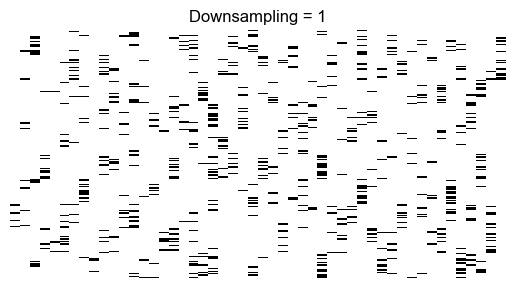

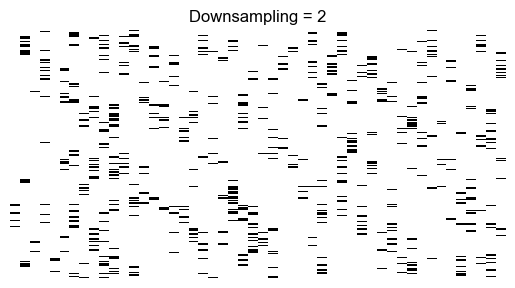

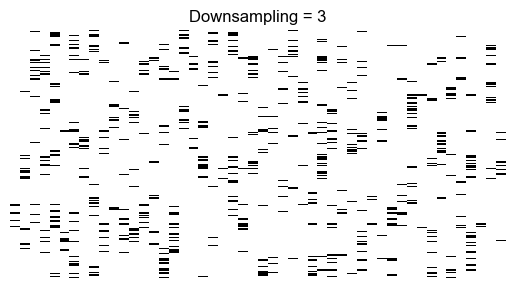

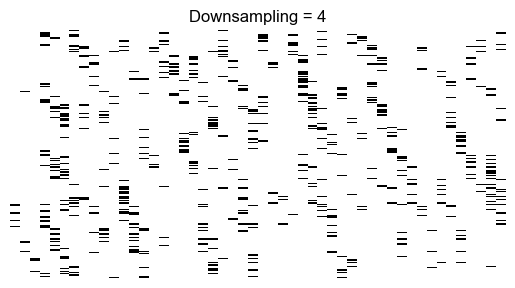

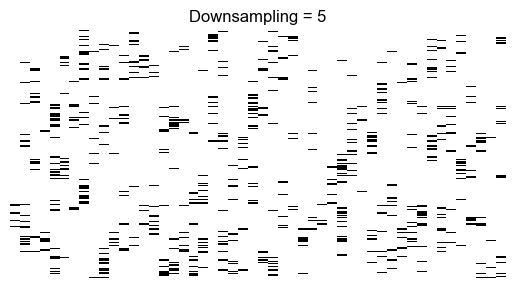

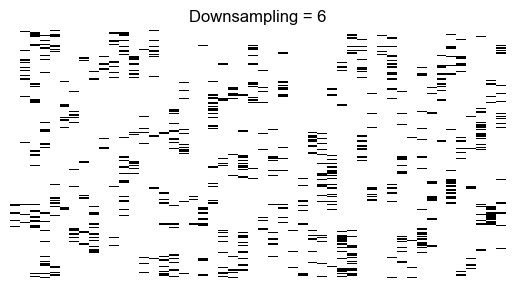

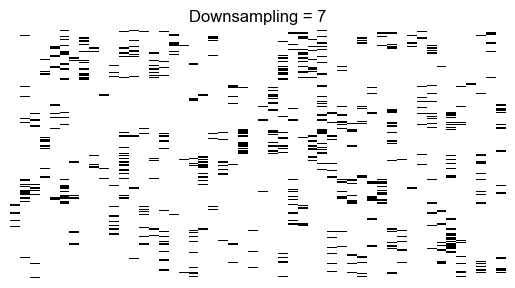

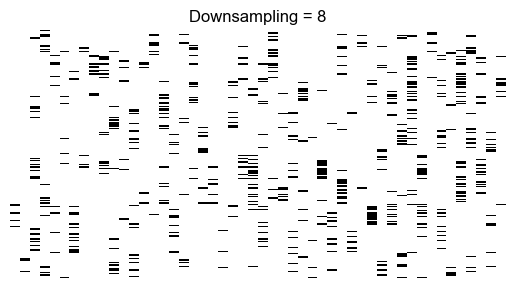

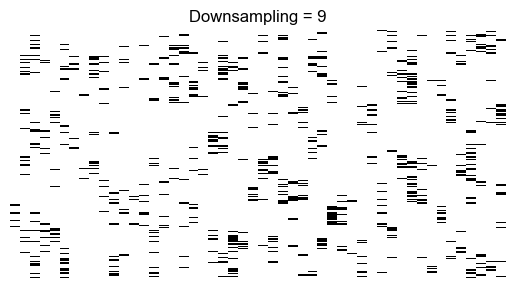

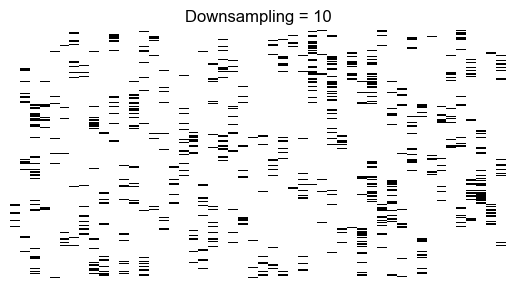

In [36]:
data = test_data[..., 0] # data from first batch
n_show = 50

for ds in range(1, 11):
    plt.figure()
    plt.title("Downsampling = {}".format(ds))
    #plt.imshow(mean_data[:, offset::ds][:, :n_show], cmap='binary', interpolation='none', aspect = 0.1*(n_show/n_h), vmax=0.75)
    plt.imshow(data[:, ::ds][:, :n_show], cmap='binary', interpolation='none', aspect = 0.5*(n_show/(neurons_per_population*n_h)), vmax=0.75)
    
#     plt.gca().set_yticks([])
#     plt.gca().set_xticks([])
    plt.gca().axis('off')
    plt.show()

In [58]:
# separate images
from PIL import Image

n_v = n_h*neurons_per_population
n_ds = 10
n_show = 200

output_path = 'images/downsampled/'

for ds in [1, 4]:
    img = Image.fromarray(255 * np.array(1 - data[:, ::ds][:, :n_show]).astype('uint8'), mode='L')
    img.save(output_path + 'NEW_downsampled_{}.png'.format(ds))

# Variance estimate in data generation

In [5]:
# Modified version of data generation algorithm, that is used to find many instances of
# of the background (= population without interaction) waves applied to known population states.

class PoissonTimeShiftedDataModified(PoissonTimeShiftedData):
    def __init__(
            self, lambda_init, neurons_per_population=10, n_populations=20, n_batches=200, time_steps_per_batch=100,
             delay=1, U=None, norm=1, **kwargs):

        """
        """
        if 'int_range' not in kwargs:  # Interval Range External Input
            kwargs['int_range'] = [5, 10]
        if 'ex_fr_range' not in kwargs:  # lower and upper bound of firing rate of external input
            kwargs['ex_fr_range'] = [0, 1.5]
        if 'std_range' not in kwargs:  # width of gaussian shaped peaks
            kwargs['std_range'] = [1, 2]
        if 'bound_fr_range' not in kwargs:  # lower and upper bound of firing rate after modulation
            kwargs['bound_fr_range'] = 3 * np.array(kwargs['ex_fr_range'])
        if 'spread_fr' not in kwargs: # firing rate spread inside one hidden population
            kwargs['spread_fr'] = [0.6, 1.4]

        self.kwargs = kwargs
            
        # If U is not given, create U with sequential firing of populations
        if U is None:
            U = create_U_hat(n_populations)
            U /= norm

        self.data = torch.empty(
            neurons_per_population * n_populations,
            time_steps_per_batch,
            n_batches,
            dtype=torch.float
        )

        population_waves = torch.zeros(n_populations, time_steps_per_batch + 1, n_batches)
        neuron_waves_interact = torch.zeros(neurons_per_population * n_populations, time_steps_per_batch, n_batches)
        idx = [torch.randperm(neurons_per_population) for _ in range(n_populations)]


        # get all mother trains by looping over populations
        for h in tqdm(range(n_populations)):
            background_wave = self.get_random_peaks(
                time_steps_per_batch=time_steps_per_batch + 1, n_batches=n_batches,
                n=10, **kwargs)

            population_waves[h, :, :] = self.get_random_peaks(
                time_steps_per_batch=time_steps_per_batch + 1, n_batches=n_batches,
                **kwargs) + background_wave

            
        # Set initial lambda / population waves
        population_waves[:, 0, :] = lambda_init.detach().clone()
            
        self.population_waves_original = population_waves.detach().clone()

        # compute interactions of all populations on their resulting firing rate
        for t in range(1, time_steps_per_batch + 1):
            for h in range(n_populations):
                population_waves[h, t, :] += torch.sum(
                    U[:, h][None, :, None] * population_waves[:, 0, :], (0, 1)
                ) / n_populations

            # constrain to only positive values, lower & upper limit and remove nan
            population_waves[:, t, :] = self.constraints(population_waves[:, t, :], **kwargs)

        # skip first step as it contains the initial condition
        population_waves = population_waves[:, 1:, :]

        
        for h in range(n_populations):
            neuron_waves_interact[neurons_per_population * h: neurons_per_population * (h + 1), ...] = \
                (population_waves[h, ...]).repeat(neurons_per_population, 1, 1) * \
                torch.linspace(kwargs['spread_fr'][0], kwargs['spread_fr'][1], neurons_per_population)[idx[h], None, None]

        self.data = torch.poisson(neuron_waves_interact)

        # make sure there are
        self.data[self.data < 0] = 0
        self.data[self.data > 1] = 1
        self.population_waves_interact = population_waves
        self.neuron_waves_interact = neuron_waves_interact
        self.firing_rates = torch.mean(self.data, (1, 2))
        self.delay = delay
        self.time_steps_per_batch = time_steps_per_batch
        self.U = U
        
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [7]:
%%time
U_hat = create_U_hat(n_h) / 0.15
delay = 4

# Generate own test data, for consistency
# (This is exactly the same test data as used for the test accuracy measure)
np.random.seed(1)
torch.random.manual_seed(1)

# create data
s = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=1000,
    time_steps_per_batch=1000 + 25,
    delay=delay, U=U_hat.T,
    int_range=int_range, fr_range=fr_range, std_range=std_range)

# discard first 25 timesteps, as initial activity is different from long time activity
test_data = s.data[:, 25:].detach().clone()

Wall time: 2min 55s


In [8]:
torch.random.manual_seed(0)
np.random.seed(0)

# SIMULATION PLAN:
# Every batch has their own l_init = starting population wave, which is sampled from the distribution
# of all population waves. Then, for every time step, the population wave is exactly as if the
# previous time step was the initial population wave.

# Doing this gives an estimate of the variance in population waves due to the background/original
# population waves.
# This is repeated for many batches with different starting states to yield a representative average
# of the possible states.


# Sample population states directly from true distribution of population waves

MSE_lower_bound_mean = np.empty(10)
MSE_lower_bound_sem = np.empty(10)

for ds in range(1, 11):
    print("{}x downsampling:".format(ds))
    T = 100*1000
    waves = reshape_fortran(s.population_waves_interact[:, 25::ds][:, :100], shape=[n_h, T])

    n_batches = 10000 # number of initial waves to use
    # NOTE: This many batches takes quite some time to simulate
    time_steps_per_batch = 1025 # number of background samples per initial wave


    selected_waves = np.random.choice(np.arange(T), size=n_batches, replace=False)

    l_init = waves[:, selected_waves]

    print("Generating interactions..")
    s_modified = PoissonTimeShiftedDataModified(l_init,
        neurons_per_population=neurons_per_population,
        n_populations=n_h, n_batches=n_batches,
        time_steps_per_batch=time_steps_per_batch,
        delay=delay, U=U_hat.T,
        int_range=int_range, fr_range=fr_range, std_range=std_range)
    
    # Calculate MSE for each batch. The mean of these is an estimate of the lower bound on the
    # MSE for a model with perfect knowledge of the underlying population waves from previous
    # timesteps.

    torch.random.manual_seed(2)
    np.random.seed(2)

    MSE = np.empty([n_batches])

    print("Calculating MSE...")
    for batch in tqdm(range(n_batches)):
        data1 = torch.poisson(s_modified.neuron_waves_interact[..., batch])
        data2 = torch.poisson(s_modified.neuron_waves_interact[..., batch].flip(1)) # sample with waves in reverse order

        # The idea is that data1 and data2 have different background waves for identical population wave states,
        # such that the MSE between the two corresponds to a model with perfect knowledge of the previous population state.

        data1[data1 > 1] = 1
        data2[data2 > 1] = 1

        MSE[batch] = torch.sum(torch.abs(data1 - data2)).cpu() / data1.numel()
        # = var(data1 - data2) = (on average) 2*var(data1)

    MSE_lower_bound_mean[ds-1] = np.mean(MSE)
    MSE_lower_bound_sem[ds-1] = np.std(MSE) / np.sqrt(n_batches)
    print("MSE lower bound = {:.10f} +- {:.10f}".format(np.mean(MSE), np.std(MSE) / np.sqrt(n_batches)))

1x downsampling:
Generating interactions..


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [14:11<00:00, 85.14s/it]


Calculating MSE...


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:14<00:00, 18.03it/s]


MSE lower bound = 0.1145992430 +- 0.0001650191
2x downsampling:
Generating interactions..


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:47<00:00, 76.73s/it]


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 8200000000 bytes.

In [ ]:
# save results
np.save('MSE_lower_mean.npy', MSE_lower_bound_mean)
np.save('MSE_lower_std.npy', MSE_lower_bound_sem)


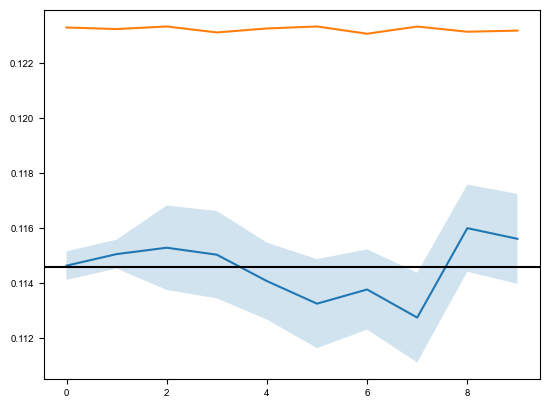

In [36]:
plt.plot(MSE_lower_bound_mean)
plt.fill_between(np.arange(10), MSE_lower_bound_mean - MSE_lower_bound_sem, MSE_lower_bound_mean + MSE_lower_bound_sem, alpha=0.2)

plt.gca().axhline(mean_lower_MSE, c='k')

plt.plot(theoretical_errors)

plt.show()

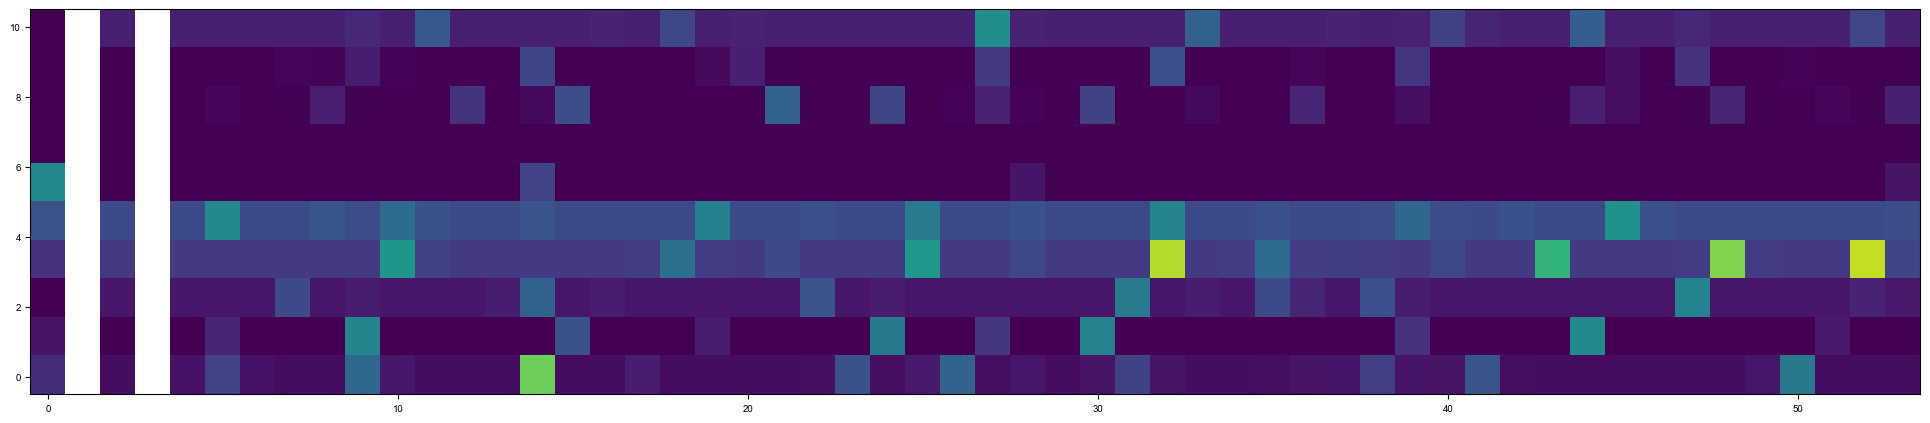

In [20]:
# Show result of simulation
# this shows in the first column the starting state (lambda(t-1)),
# followed by a column for the expected state after interactions (lambda(t)) without intrinsic waves,
# and then many sampled instances of this state with the intrinsic waves.

n_show = 50
extent = np.array([3.5, n_show + 3.5, -0.5, n_h + 0.5])
extent2 = np.array([-0.5, 0.5, -0.5, n_h + 0.5])

batch = 4
l_interact = torch.zeros_like(l_init[:, batch])

for h in range(n_h):
    l_interact[h] = torch.sum(U_hat.T[:, h] * l_init[:, batch]) / n_h
    
l_interact = s_modified.constraints(l_interact, **s_modified.kwargs)

plt.figure(figsize = (n_show/2, 5))

# Show initial state and interacted state without background activity
plt.imshow(np.array([l_init[:, batch].numpy()]).T, extent=extent2, vmin=0, vmax=1)
plt.imshow(np.array([l_interact.numpy()]).T, extent=extent2 + [2, 2, 0, 0], vmin=0, vmax=1)

# Show some instances with background activity
plt.imshow(s_modified.population_waves_interact[:, 1:n_show+1, batch], extent=extent, vmin=0, vmax=1)

plt.xlim([extent2[0], extent[1]])
plt.show()

In [21]:
# Calculate MSE for each batch. The mean of these is an estimate of the lower bound on the
# MSE for a model with perfect knowledge of the underlying population waves from previous
# timesteps.

torch.random.manual_seed(2)
np.random.seed(2)

MSE = np.empty([n_batches])

for batch in tqdm(range(n_batches)):
    data1 = torch.poisson(s_modified.neuron_waves_interact[..., batch])
    data2 = torch.poisson(s_modified.neuron_waves_interact[..., batch].flip(1)) # sample with waves in reverse order
    
    # The idea is that data1 and data2 have different background waves for identical population wave states,
    # such that the MSE between the two corresponds to a model with perfect knowledge of the previous population state.

    data1[data1 > 1] = 1
    data2[data2 > 1] = 1

    MSE[batch] = torch.sum(torch.abs(data1 - data2)).cpu() / data1.numel()
    # = var(data1 - data2) = (on average) 2*var(data1)
    
print("MSE lower bound = {:.10f} +- {:.10f}".format(np.mean(MSE), np.std(MSE) / np.sqrt(n_batches)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.44it/s]

MSE lower bound = 0.1146200487 +- 0.0016060043


This is the bound used in the performance plot